# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

**Описание данных**

- *RowNumber* — индекс строки в данных
- *CustomerId* — уникальный идентификатор клиента
- *Surname* — фамилия
- *CreditScore* — кредитный рейтинг
- *Geography* — страна проживания
- *Gender* — пол
- *Age* — возраст
- *Tenure* — сколько лет человек является клиентом банка
- *Balance* — баланс на счёте
- *NumOfProducts* — количество продуктов банка, используемых клиентом
- *HasCrCard* — наличие кредитной карты
- *IsActiveMember* — активность клиента
- *EstimatedSalary* — предполагаемая зарплата
- *Exited* — факт ухода клиента

In [11]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

import statsmodels.api as sm

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, roc_auc_score, precision_recall_curve, roc_curve 
from sklearn.utils import shuffle

## Подготовка данных

Загрузим данные и посмотрим на них.

In [12]:
df = pd.read_csv('datasets/Churn.csv', index_col=0)
df.info()
df.sample(n=10, random_state=42)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 1 to 10000
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CustomerId       10000 non-null  int64  
 1   Surname          10000 non-null  object 
 2   CreditScore      10000 non-null  int64  
 3   Geography        10000 non-null  object 
 4   Gender           10000 non-null  object 
 5   Age              10000 non-null  int64  
 6   Tenure           9091 non-null   float64
 7   Balance          10000 non-null  float64
 8   NumOfProducts    10000 non-null  int64  
 9   HasCrCard        10000 non-null  int64  
 10  IsActiveMember   10000 non-null  int64  
 11  EstimatedSalary  10000 non-null  float64
 12  Exited           10000 non-null  int64  
dtypes: float64(3), int64(7), object(3)
memory usage: 1.1+ MB


,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
RowNumber,,,,,,,,,,,,,
6253,15687492,Anderson,596,Germany,Male,32,3.0,96709.07,2,0,0,41788.37,0
4685,15736963,Herring,623,France,Male,43,1.0,0.00,2,1,1,146379.30,0
1732,15721730,Amechi,601,Spain,Female,44,4.0,0.00,2,1,0,58561.31,0
4743,15762134,Liang,506,Germany,Male,59,8.0,119152.10,2,1,1,170679.74,0
4522,15648898,Chuang,560,Spain,Female,27,7.0,124995.98,1,1,1,114669.79,0
6341,15659064,Salas,790,Spain,Male,37,8.0,0.00,2,1,1,149418.41,0
577,15761986,Obialo,439,Spain,Female,32,NaN,138901.61,1,1,0,75685.97,0
5203,15713354,Morrice,597,Germany,Female,22,6.0,101528.61,1,1,0,70529.00,1
6364,15593454,Lambert,678,Spain,Female,40,4.0,113794.22,1,1,0,16618.76,0


В таблице 10 тысяч объектов. В столбце Tenure есть пропуски. Хорошо было бы выяснить, почему они появились. Возможно, это очень старые клиенты и дата их появления утеряна. Возможно, эти клиенты были унаследованы из другого, поглащённого, банка, где учёт вёлся в другом формате, поэтому данные подгрузились неполностью. Т.к. достоверно восстановить пропущенные значения невозможно, строки с пропусками можно было бы удалить. Но эти объекты содержат другие ценные признаки, поэтому лучшим решением будет заполнить пропущенные значения так, чтобы новые значения Tenure в меньшей степени влияли на целевой признак. Заполним пропуски медианным значением и посмотрим, как изменится график зависимости доли положительных значений Exited от значения Tenure.

In [13]:
df[['Tenure']].describe()

,Tenure
count,9091.000000
mean,4.997690
std,2.894723
min,0.000000
25%,2.000000
50%,5.000000
75%,7.000000
max,10.000000


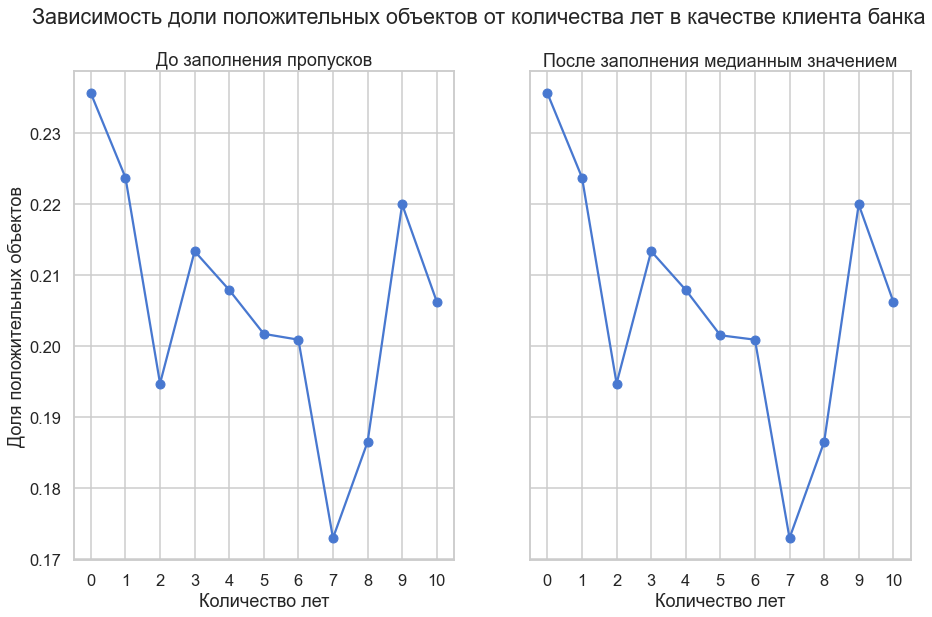

In [14]:
sns.set(context='talk', style='whitegrid', palette='muted')
f, ax = plt.subplots(1, 2, sharey=True)
f.set_figheight(9)
f.set_figwidth(15)
f.suptitle('Зависимость доли положительных объектов от количества лет в качестве клиента банка')

data_before = df.pivot_table(index='Tenure', values='Exited', aggfunc='mean')
data_before.plot(ax=ax[0], style='o-', xlim=(-0.5, 10.5), legend=False)

df = df.fillna(df['Tenure'].median())

data_after = df.pivot_table(index='Tenure', values='Exited', aggfunc='mean')
data_after.plot(ax=ax[1], style='o-', xlim=(-0.5, 10.5), legend=False)

ax[0].set_title('До заполнения пропусков')
ax[1].set_title('После заполнения медианным значением')
ax[0].set(xlabel='Количество лет', ylabel='Доля положительных объектов')
ax[1].set(xlabel='Количество лет', ylabel='')
ax[0].xaxis.set_major_locator(ticker.MultipleLocator(1))
ax[1].xaxis.set_major_locator(ticker.MultipleLocator(1))

plt.show()

Замена не должна повлиять на зависимость Exited от значения Tenure. Кажется, вообще никаких изменений нет. Посмотрим поближе.

In [15]:
df[['Tenure']].describe()

,Tenure
count,10000.00000
mean,4.99790
std,2.76001
min,0.00000
25%,3.00000
50%,5.00000
75%,7.00000
max,10.00000


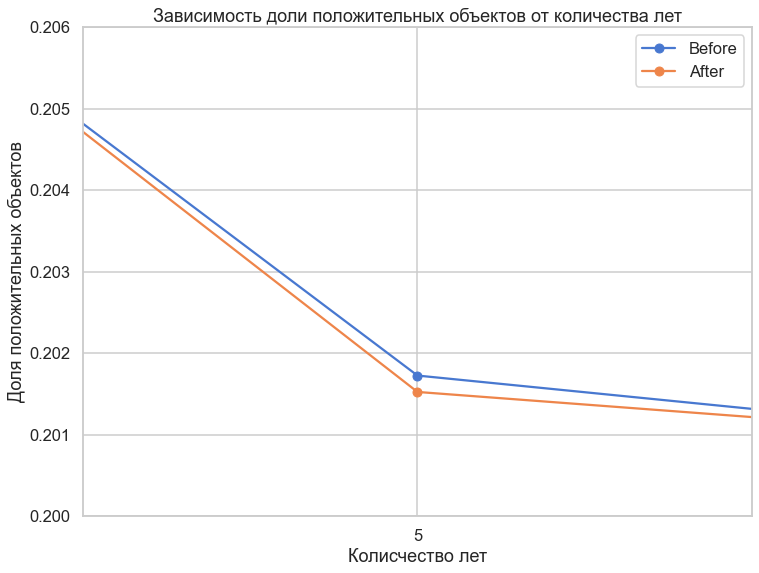

In [16]:
f, ax = plt.subplots(1)
f.set_figheight(9)
f.set_figwidth(12)

plt.plot(data_before.index, 'Exited', data=data_before, marker = 'o', label='Before')
plt.plot(data_after.index, 'Exited', data=data_after, marker = 'o', label='After')

plt.ylim(0.2, 0.206)
plt.xlim(4.5, 5.5)

plt.legend(title='')
plt.title('Зависимость доли положительных объектов от количества лет')
plt.ylabel('Доля положительных объектов')
plt.xlabel('Колисчество лет')

ax.xaxis.set_major_locator(ticker.MultipleLocator(1))

plt.show()

Замена пропусков в Tenure на медианные значения незначительно повлияла на общую картину. Преобразуем тип столбца в int.

In [17]:
df['Tenure'] = df['Tenure'].astype('int')

Типы столбцов Gender и Geography можно преобразовать в category. Посмотрим на количество вариантов значений.

In [18]:
df['Gender'].value_counts()

Male      5457
Female    4543
Name: Gender, dtype: int64

In [19]:
df['Geography'].value_counts()

France     5014
Germany    2509
Spain      2477
Name: Geography, dtype: int64

Количество вариантов значений столбцов незначительное, преобразуем тип.

In [20]:
df['Gender'] = df['Gender'].astype('category')
df['Geography'] = df['Geography'].astype('category')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 1 to 10000
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   CustomerId       10000 non-null  int64   
 1   Surname          10000 non-null  object  
 2   CreditScore      10000 non-null  int64   
 3   Geography        10000 non-null  category
 4   Gender           10000 non-null  category
 5   Age              10000 non-null  int64   
 6   Tenure           10000 non-null  int64   
 7   Balance          10000 non-null  float64 
 8   NumOfProducts    10000 non-null  int64   
 9   HasCrCard        10000 non-null  int64   
 10  IsActiveMember   10000 non-null  int64   
 11  EstimatedSalary  10000 non-null  float64 
 12  Exited           10000 non-null  int64   
dtypes: category(2), float64(2), int64(8), object(1)
memory usage: 957.3+ KB


Целевым признаком является Exited. Среди остальных признаков есть CustomerId и Surname, которые однозначно определяют клиента, но не подходят для прогнозирования его ухода.

In [21]:
target = df['Exited']
features = df.drop(['CustomerId','Surname','Exited'], axis=1)

print('Размер таблицы с признаками:', features.shape)
print('Размер столбца с целевым признаком:', target.shape)

Размер таблицы с признаками: (10000, 10)
Размер столбца с целевым признаком: (10000,)


Значения столбцов HasCrCard, IsActiveMember и Exited по смыслу должны содержать значения 0 и 1. Проверим, что это действительно так.

In [22]:
print('Варианты значений столбца HasCrCard:', df['HasCrCard'].unique())
print('Варианты значений столбца IsActiveMember:', df['IsActiveMember'].unique())
print('Варианты значений столбца Exited:', df['Exited'].unique())

Варианты значений столбца HasCrCard: [1 0]
Варианты значений столбца IsActiveMember: [1 0]
Варианты значений столбца Exited: [1 0]


Преобразуем категориальные признаки с помощью прямого кодирования.

In [23]:
features = pd.get_dummies(features, drop_first=True)
features.sample(n=10, random_state=42)

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
RowNumber,,,,,,,,,,,
6253,596,32,3,96709.07,2,0,0,41788.37,1,0,1
4685,623,43,1,0.00,2,1,1,146379.30,0,0,1
1732,601,44,4,0.00,2,1,0,58561.31,0,1,0
4743,506,59,8,119152.10,2,1,1,170679.74,1,0,1
4522,560,27,7,124995.98,1,1,1,114669.79,0,1,0
6341,790,37,8,0.00,2,1,1,149418.41,0,1,1
577,439,32,5,138901.61,1,1,0,75685.97,0,1,0
5203,597,22,6,101528.61,1,1,0,70529.00,1,0,0
6364,678,40,4,113794.22,1,1,0,16618.76,0,1,0


Перед масштабированием посмотрим с помощью QQ-plot, на сколько распределения значений численных признаков в features отличаются от нормального.

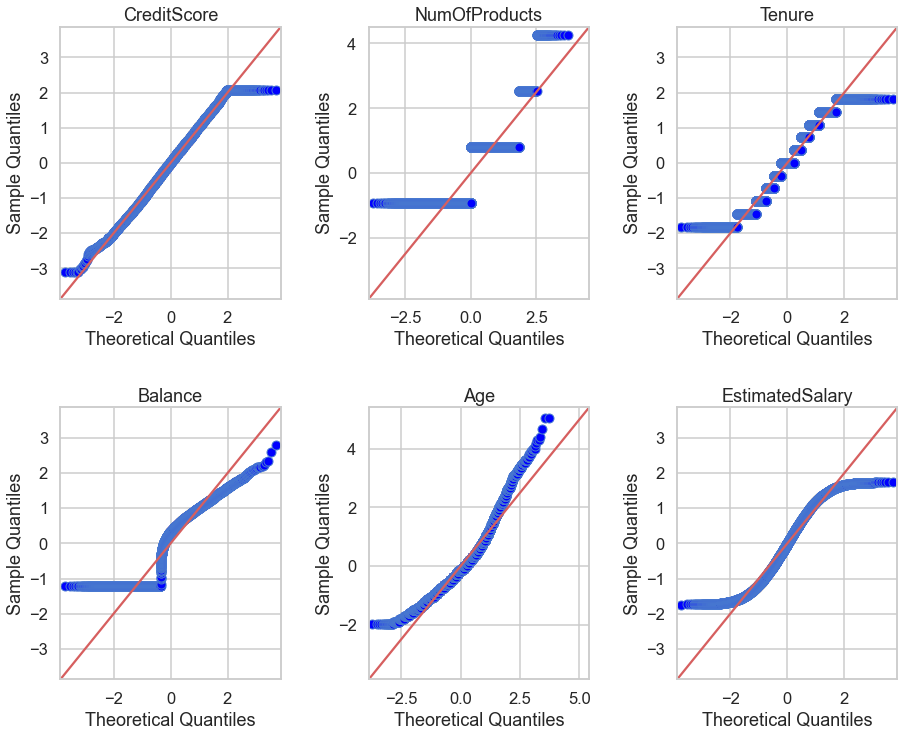

In [24]:
f, ax = plt.subplots(2, 3, gridspec_kw={'hspace': 0.4, 'wspace': 0.4})
f.set_figheight(12)
f.set_figwidth(15)

numeric = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']

for i, column_name in enumerate(numeric):
    sm.qqplot(features[column_name], line='45', fit=True, ax=ax[i%2, i%3])
    ax[i%2, i%3].set_title(column_name)

Количество банковских продуктов - это, скорее, категориальный признак. Посмотрим на количество уникальных значений и закодируем по аналогии с полом и страной.

In [25]:
print('Варианты значений столбца NumOfProducts:', df['NumOfProducts'].unique())

Варианты значений столбца NumOfProducts: [1 3 2 4]


Здесь было бы правильно убедиться, что 4 - это максимально возможное количество банковских продуктов. Предположим, что это так.

In [26]:
features['NumOfProducts'] = features['NumOfProducts'].astype('category')
features = pd.get_dummies(features, drop_first=True)
features.sample(n=10, random_state=42)

,CreditScore,Age,Tenure,Balance,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male,NumOfProducts_2,NumOfProducts_3,NumOfProducts_4
RowNumber,,,,,,,,,,,,,
6253,596,32,3,96709.07,0,0,41788.37,1,0,1,1,0,0
4685,623,43,1,0.00,1,1,146379.30,0,0,1,1,0,0
1732,601,44,4,0.00,1,0,58561.31,0,1,0,1,0,0
4743,506,59,8,119152.10,1,1,170679.74,1,0,1,1,0,0
4522,560,27,7,124995.98,1,1,114669.79,0,1,0,0,0,0
6341,790,37,8,0.00,1,1,149418.41,0,1,1,1,0,0
577,439,32,5,138901.61,1,0,75685.97,0,1,0,0,0,0
5203,597,22,6,101528.61,1,0,70529.00,1,0,0,0,0,0
6364,678,40,4,113794.22,1,0,16618.76,0,1,0,0,0,0


Остальные признаки отклоняются от нормального распределения на больших и маленьких значениях, но в целом их можно принять как нормальные.

In [27]:
numeric = ['CreditScore', 'Age', 'Tenure', 'Balance', 'EstimatedSalary']

Посмотрим на корреляцию признаков. Если какие-то признаки хорошо коррелируют между собой, один из них нужно будет убрать из рассмотрения.

In [28]:
features[numeric].corr()

,CreditScore,Age,Tenure,Balance,EstimatedSalary
CreditScore,1.000000,-0.003965,-0.000060,0.006268,-0.001384
Age,-0.003965,1.000000,-0.012606,0.028308,-0.007201
Tenure,-0.000060,-0.012606,1.000000,-0.007535,0.010049
Balance,0.006268,0.028308,-0.007535,1.000000,0.012797
EstimatedSalary,-0.001384,-0.007201,0.010049,0.012797,1.000000


Численные признаки не коррелируют между собой.

Разделим данные на обучающую, валидационную и тестовую выборки в соотношении 3:1:1. Функция train_test_split делит датасет только на две части, поэтому воспользуемся ей дважды: на первом шаге выделим 20% на тестовую часть часть, а на втором - разделим оставшиеся 80% на обучающую и валидационную выборки.

In [29]:
features_train_80, features_test, target_train_80, target_test = train_test_split(
    features, target, test_size=0.2, random_state=42, stratify = target
)
features_train, features_valid, target_train, target_valid = train_test_split(
    features_train_80, target_train_80, test_size=0.25, random_state=42, stratify = target_train_80
)
print('Рамер обучающей выборки:', features_train.shape, target_train.shape)
print('Рамер валидационной выборки:', features_valid.shape, target_valid.shape)
print('Рамер тестовой выборки:', features_test.shape, target_test.shape)

Рамер обучающей выборки: (6000, 13) (6000,)
Рамер валидационной выборки: (2000, 13) (2000,)
Рамер тестовой выборки: (2000, 13) (2000,)


Отмасштабируем признаки.

In [30]:
pd.options.mode.chained_assignment = None

scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])
features_train_80[numeric] = scaler.transform(features_train_80[numeric])

features_train.sample(n=10, random_state=42)

,CreditScore,Age,Tenure,Balance,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male,NumOfProducts_2,NumOfProducts_3,NumOfProducts_4
RowNumber,,,,,,,,,,,,,
9817,-0.083844,0.862523,1.079907,-1.240550,1,0,1.314234,0,1,1,1,0,0
6850,0.671557,0.480890,-1.440156,-1.240550,1,1,0.919306,0,0,0,0,0,0
7621,-0.746114,-1.141051,1.439916,-1.240550,1,0,0.478131,0,0,0,1,0,0
9347,0.671557,0.194665,1.439916,-1.240550,1,1,0.241196,0,0,1,0,0,0
1563,0.443902,-0.759418,0.359889,0.510463,1,1,-1.396746,1,0,1,1,0,0
40,-0.715070,0.194665,0.359889,-0.110977,0,1,1.372629,1,0,1,1,0,0
5129,-1.480819,-0.091560,-0.720138,1.430121,0,1,-1.341485,0,0,0,1,0,0
5928,-0.766810,0.385481,-0.720138,0.813738,0,0,0.448486,1,0,0,0,0,0
1186,1.085475,-0.186968,-0.720138,0.888933,1,1,-0.706693,0,0,1,0,0,0


**Вывод**

Данные были загружены и проанализированы. Пропущенные значения Tenure заполнены медианным значением. В отдельные таблицы выделены признаки и целевой признак. Данные разделены на обучающую, валидационную и тестовую выборки в соотношении 3:1:1. Категориальные данные преобразованны с помощью прямого кодирования, а численные параметры отмасштабированы.

## Исследование задачи

Посмотрим, какое количество положительных объектов есть в обучающей выборке.

In [21]:
print('Процент положительных объектов в обучающей выборке: {:.2%}'.format(target_train.mean()))

Процент положительных объектов в обучающей выборке: 20.38%


Наблюдается дисбаланс классов: положительных значительно меньше 50%. Но 20% - это тоже достаточно много. Попробуем найти хорошую модель без учёта дисбаланса. 

В качестве первой модели рассмотрим решающее дерево. Переберём варианты глубины дерева от 3 до 12 и найдём лучшую модель. Т.к. классы несбалансированы, accuracy не подойдёт в качестве метрики, поэтому будем вычислять F1 на валидационной выборке и искать максимальное значение. Параллельно будем считать площадь под ROC-кривой: для хорошей модели, работающей лучше случайного выбора, она должна быть больше 0,5.

In [22]:
def fitting_model (model, x, y):
    model.fit(x, y)
    f1 = f1_score(target_valid, model.predict(features_valid))
    auc_roc = roc_auc_score(target_valid, model.predict_proba(features_valid)[:,1])
    return model, f1, auc_roc

f1_tree = 0

for depth in range(3, 13):
    model = DecisionTreeClassifier(max_depth = depth, random_state=42)
    model, f1, auc_roc = fitting_model(model, features_train, target_train)
    
    if (f1 > f1_tree) and (auc_roc > 0.5):
        model_tree = model
        depth_tree = depth
        f1_tree = f1
        auc_roc_tree = auc_roc
        
print('F1 = {:.3f}'.format(f1_tree))
print('AUC_ROC = {:.3f}'.format(auc_roc_tree))
print('Глубина дерева:', depth_tree)

F1 = 0.550
AUC_ROC = 0.828
Глубина дерева: 7


Значение F1 получилось меньше 0,59. Попробуем модель случайного леса. Переберём 10 вариантов леса с количеством деревьев от 10 до 55 с шагом 5. Для каждого леса переберём варианты максимальной глубины дерева от 6 до 10. Итого это 50 моделей. Найдём, какая из них даст большее значение F1.

In [23]:
f1_forest = 0

for estimators in range(10, 56, 5):
    for depth in range(6, 11):
        model = RandomForestClassifier(n_estimators = estimators, max_depth = depth, random_state=42)
        model, f1, auc_roc = fitting_model(model, features_train, target_train)
    
        if (f1 > f1_forest) and (auc_roc > 0.5):
            model_forest = model
            estimators_forest = estimators
            depth_forest = depth
            f1_forest = f1
            auc_roc_forest = auc_roc

print('F1 = {:.3f}'.format(f1_forest))
print('AUC_ROC = {:.3f}'.format(auc_roc_forest))
print('Количество деревьев в модели:', estimators_forest)
print('Максимальная глубина дерева:', depth_forest)

F1 = 0.570
AUC_ROC = 0.857
Количество деревьев в модели: 30
Максимальная глубина дерева: 10


Модель случайного леса тоже не даёт удовлетворительные результаты на валидационной выборке. 

Рассмотрим логистическую регрессию. Для двух вариантов значений penalty - l1 и l2 - переберём по 10 вариантов значений C: от 0,2 до 2 с шагом 0,2.

In [24]:
f1_regression = 0

for l in ['l1','l2']:
    for c in np.arange(0.2, 2.1, 0.2):
        model = LogisticRegression(penalty=l, C=c, random_state=42, solver='liblinear')
        model, f1, auc_roc = fitting_model(model, features_train, target_train)
    
        if (f1 > f1_regression) and (auc_roc > 0.5):
            model_regression = model
            l_regression = l
            c_regression = c
            f1_regression = f1
            auc_roc_regression = auc_roc
            
print('F1 = {:.3f}'.format(f1_regression))
print('AUC_ROC = {:.3f}'.format(auc_roc_regression))
print('Penalty =', l_regression)
print('C = {:.1f}'.format(c_regression))

F1 = 0.484
AUC_ROC = 0.825
Penalty = l1
C = 0.8


Логистическая регрессия даёт наихудшие результаты.

**Вывод**

Рассмотрены 3 модели: дерево, лес и логистическая регрессия с 10, 50 и 20 наборами гиперпараметров соответственно. Дисбаланс классов не учитывался. В качестве метрики использовано значение F1, также была посчитана площадь под ROC-кривой. Лучшие результаты дал лес с 30 деревьями и максимальной глубиной дерева 10: F1 = 0,57 на валидационной выборке. Решающее дерево и логистическая регрессия показали F1 = 0,55 и F1 = 0,484 соответственно. Без учёта дисбаланса не удалось преодолеть пороговое значение F1 = 0,59.

## Борьба с дисбалансом

Попробуем сбалансировать классы с помощью аргумента class_weight. Посмотрим, поможет ли это улучшить показатели моделей.

In [25]:
model_tree_balanced = DecisionTreeClassifier(
    max_depth = depth_tree, class_weight = 'balanced', random_state=42)
model_tree_balanced, f1_tree_balanced, auc_roc_tree_balanced = \
    fitting_model (model_tree_balanced, features_train, target_train)

print('Решающее дерево')
print('F1 = {:.3f}'.format(f1_tree_balanced))
print('AUC_ROC = {:.3f}'.format(auc_roc_tree_balanced))
print()

Решающее дерево
F1 = 0.570
AUC_ROC = 0.809



In [26]:
model_forest_balanced = RandomForestClassifier(
    n_estimators = estimators_forest, max_depth = depth_forest, class_weight = 'balanced', random_state=42)
model_forest_balanced, f1_forest_balanced, auc_roc_forest_balanced = \
    fitting_model (model_forest_balanced, features_train, target_train)

print('Случайный лес')
print('F1 = {:.3f}'.format(f1_forest_balanced))
print('AUC_ROC = {:.3f}'.format(auc_roc_forest_balanced))
print()

Случайный лес
F1 = 0.612
AUC_ROC = 0.853



In [27]:
model_regression_balanced = LogisticRegression(
    penalty=l_regression, C=c_regression, class_weight = 'balanced', random_state=42, solver='liblinear')
model_regression_balanced, f1_regression_balanced, auc_roc_regression_balanced = \
    fitting_model (model_regression_balanced, features_train, target_train)

print('Логистическая регрессия')
print('F1 = {:.3f}'.format(f1_regression_balanced))
print('AUC_ROC = {:.3f}'.format(auc_roc_regression_balanced))

Логистическая регрессия
F1 = 0.545
AUC_ROC = 0.826


Все модели улучшили F1 на валидационной выборке. Случайный лес преодолел порог 0.59 - такую модель можно использоаать.

Попробуем увеличить выборку положительных объектов и переобучить модели. Т.к. положительных объектов в выборке больше 20%, увеличение их количества в 4 раза приведёт к тому, что количество положительных превысит количество отрицательных. Увеличим выборку в 2 раза и в 3 - и выберем лучший вариант.

In [28]:
def upsample (features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=42)
    
    return features_upsampled, target_upsampled

f1_tree_upsample = 0
f1_forest_upsample = 0
f1_regression_upsample = 0

for repeat in [2, 3]:
    features_upsampled, target_upsampled = upsample(features_train, target_train, repeat)
    
    model = DecisionTreeClassifier(max_depth = depth_tree, random_state=42)
    model, f1, auc_roc = fitting_model(model, features_upsampled, target_upsampled)

    if f1 > f1_tree_upsample:
        model_tree_upsample = model
        repeat_tree_upsample = repeat
        f1_tree_upsample = f1
        auc_roc_tree_upsample = auc_roc

    model = RandomForestClassifier(n_estimators = estimators_forest, max_depth = depth_forest, random_state=42)
    model, f1, auc_roc = fitting_model(model, features_upsampled, target_upsampled)
    
    if f1 > f1_forest_upsample:
        model_forest_upsample = model
        repeat_forest_upsample = repeat
        f1_forest_upsample = f1
        auc_roc_forest_upsample = auc_roc
            
    model = LogisticRegression(penalty=l_regression, C=c_regression, random_state=42, solver='liblinear')
    model, f1, auc_roc = fitting_model(model, features_upsampled, target_upsampled)
    
    if f1 > f1_regression_upsample:
        model_regression_upsample = model
        repeat_regression_upsample = repeat
        f1_regression_upsample = f1
        auc_roc_regression_upsample = auc_roc
            
print('Решающее дерево')
print('F1 = {:.3f}'.format(f1_tree_upsample))
print('AUC_ROC = {:.3f}'.format(auc_roc_tree_upsample))
print('repeat =', repeat_tree_upsample)
print()
print('Случайный лес')
print('F1 = {:.3f}'.format(f1_forest_upsample))
print('AUC_ROC = {:.3f}'.format(auc_roc_forest_upsample))
print('repeat =', repeat_forest_upsample)
print()
print('Логистическая регрессия')
print('F1 = {:.3f}'.format(f1_regression_upsample))
print('AUC_ROC = {:.3f}'.format(auc_roc_regression_upsample))
print('repeat =', repeat_regression_upsample)

Решающее дерево
F1 = 0.565
AUC_ROC = 0.801
repeat = 3

Случайный лес
F1 = 0.633
AUC_ROC = 0.859
repeat = 3

Логистическая регрессия
F1 = 0.562
AUC_ROC = 0.826
repeat = 3


Лучший результат для всех трёх моделей даёт увеличение выборки положительных объектов в 3 раза. Значение F1 на валидационной выборке для случайного леса и логистической регрессии увеличилось. Показатели решающего дерева немного ухудшились по сравнению с предыдущим вариантом.

Для сравнения попробуем уменьшить выборку отрицательных объектов. Переберём разные варианты значения доли отрицательных объектов: от 0,2 до 0,8 с шагом 0,2.

In [29]:
def downsample (features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=42)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=42)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=42)
    
    return features_downsampled, target_downsampled

f1_tree_downsample = 0
f1_forest_downsample = 0
f1_regression_downsample = 0

for fraction in np.arange(0.2, 0.8, 0.2):
    features_downsampled, target_downsampled = downsample(features_train, target_train, fraction)
    
    model = DecisionTreeClassifier(max_depth = depth_tree, random_state=42)
    model, f1, auc_roc = fitting_model(model, features_downsampled, target_downsampled)

    if f1 > f1_tree_downsample:
        model_tree_downsample = model
        fraction_tree_downsample = fraction
        f1_tree_downsample = f1
        auc_roc_tree_downsample = auc_roc

    model = RandomForestClassifier(n_estimators = estimators_forest, max_depth = depth_forest, random_state=42)
    model, f1, auc_roc = fitting_model(model, features_downsampled, target_downsampled)
    
    if f1 > f1_forest_downsample:
        model_forest_downsample = model
        fraction_forest_downsample = fraction
        f1_forest_downsample = f1
        auc_roc_forest_downsample = auc_roc
            
    model = LogisticRegression(penalty=l_regression, C=c_regression, random_state=42, solver='liblinear')
    model, f1, auc_roc = fitting_model(model, features_downsampled, target_downsampled)

    if f1 > f1_regression_downsample:
        model_regression_downsample = model
        fraction_regression_downsample = fraction
        f1_regression_downsample = f1
        auc_roc_regression_downsample = auc_roc
            
print('Решающее дерево')
print('F1 = {:.3f}'.format(f1_tree_downsample))
print('AUC_ROC = {:.3f}'.format(auc_roc_tree_downsample))
print('fraction = {:.1}'.format(fraction_tree_downsample))
print()
print('Случайный лес')
print('F1 = {:.3f}'.format(f1_forest_downsample))
print('AUC_ROC = {:.3f}'.format(auc_roc_forest_downsample))
print('fraction = {:.1}'.format(fraction_forest_downsample))
print()
print('Логистическая регрессия')
print('F1 = {:.3f}'.format(f1_regression_downsample))
print('AUC_ROC = {:.3f}'.format(auc_roc_regression_downsample))
print('fraction = {:.1}'.format(fraction_regression_downsample))

Решающее дерево
F1 = 0.557
AUC_ROC = 0.816
fraction = 0.8

Случайный лес
F1 = 0.622
AUC_ROC = 0.858
fraction = 0.4

Логистическая регрессия
F1 = 0.552
AUC_ROC = 0.826
fraction = 0.4


Все три модели на уменьшенной выборке показали себя хуже, чем на увеличенной.

Лучшей моделью оказалась model_forest_upsample - модель случайного леса, обученная на увеличенной выборке. Попробуем ещё увеличить значение F1 с помощью изменения порога классификации.

In [30]:
probabilities_valid = model_forest_upsample.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

f1_best = f1_forest_upsample
threshold_best = 0.5

for threshold in np.arange(0.4, 0.6, 0.005):
    predicted_valid = probabilities_one_valid > threshold
    f1 = f1_score(target_valid, predicted_valid)
    
    if f1 > f1_best:
        f1_best = f1
        threshold_best = threshold

print('Порог = {:.3f}'.format(threshold_best))
print('F1 = {:.3f}'.format(f1_best))

Порог = 0.500
F1 = 0.633


Изменение порога не помогло увеличить значение F1. 

Валидационная выборка больше не нужна, поэтому можно использовать её для обучения модели. Переменные features_train_80, target_train_80 содержат 80% данных, которые были разделены на обучающую и валидационную выборки. Теперь можно использовать их для обучения, предварительно увеличив количество положительных классов.

In [31]:
features_upsampled, target_upsampled = upsample(features_train_80, target_train_80, repeat_forest_upsample)
model_forest_upsample.fit(features_upsampled, target_upsampled)

RandomForestClassifier(max_depth=10, n_estimators=30, random_state=42)

**Вывод**

К лучшим моделям каждого вида (дерево, лес, регрессия) применены три варианта балансировки классов: аргумент class_weight, увеличение выборки положительных объектов и уменьшение выборки отрицательных объектов. Для дерева лучшим решением оказалась балансировка классов с помощью аргумента class_weight, но значение F1 осталось меньше 0,59. Для леса и для логистической регрессии лучше всего сработало увеличение выборки, но только лес показал F1 > 0,59.

In [32]:
round(pd.DataFrame(
    [['DecisionTree', f1_tree_balanced, f1_tree_upsample, f1_tree_downsample],
     ['RandomForest', f1_forest_balanced, f1_forest_upsample, f1_forest_downsample],
     ['LogisticRegression', f1_regression_balanced, f1_regression_upsample, f1_regression_downsample]
    ],
    columns = ['model', 'f1_balanced', 'f1_upsample', 'f1_downsample']
).set_index('model'), 3)

,f1_balanced,f1_upsample,f1_downsample
model,,,
DecisionTree,0.570,0.565,0.557
RandomForest,0.612,0.633,0.622
LogisticRegression,0.545,0.562,0.552


Для лучшей модели - модели случайного леса, обученной на увеличенной выборке, был исследован порог классификации для увеличения значения F1. Выяснилось, что наилучшим пороговым значением остаётся 0,5. 

Лучшая модель была переобучена на большей выборке: обучающей и валидационной вместе.

## Тестирование модели

Проверим, даёт ли выбранная модель такие же хорошие результаты на тестовой выборке.

In [33]:
predictions_test = model_forest_upsample.predict(features_test)
probabilities_one_test = model_forest_upsample.predict_proba(features_test)[:,1]

print('F1 = {:.3f}'.format(f1_score(target_test, predictions_test)))
print('AUC_ROC = {:.3f}'.format(roc_auc_score(target_test, probabilities_one_test)))

F1 = 0.632
AUC_ROC = 0.861


Визуализируем результаты.

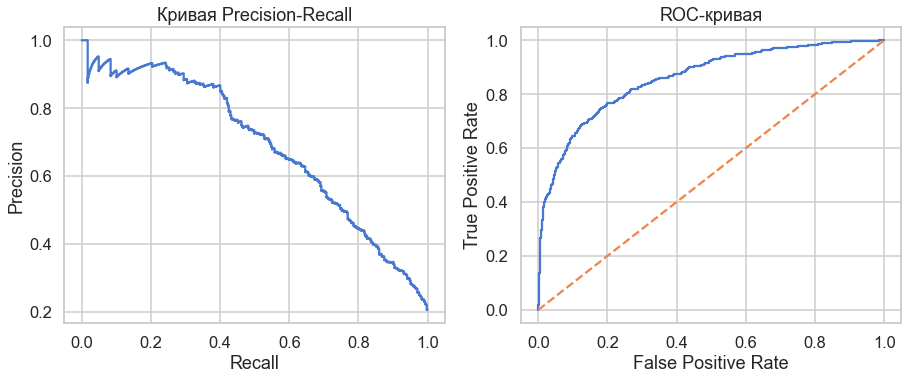

In [34]:
plt.figure(figsize=(15, 12))

plt.subplot(221)
precision, recall, thresholds = precision_recall_curve(target_test, probabilities_one_test)

plt.step(recall, precision, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Кривая Precision-Recall')

plt.subplot(222)
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)

plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')

plt.show()

Модель даёт хорошие результаты.

**Вывод**

Модель успешно прошла тест на тестовой выборке.

## Общий вывод

В работе использован датасет с 10000 объектами. Признак Tenure, отражающий количество лет в качестве клиента банка, был заполнен не для все объектов - эти пропуски были заменены на медиану. Данные были разделены на признаки и целевой признак, а также поделены на обучающую, валидационную и тестовую выборки в соотношении 3:1:1. Категориальные данные преобразованны с помощью прямого кодирования, а численные параметры отмасштабированы.

Без учёта дисбаланса были выбраны лучшие наборы гиперпараметров для моделей решающего дерева, случайного леса и логистической регрессии. В качестве основной метрики использовано значение F1, кроме того, была посчитана площадь под ROC-кривой.

Применены три варианта балансировки классов: аргумент class_weight, увеличение выборки положительных объектов и уменьшение выборки отрицательных объектов. После чего была определена лучшая модель - случайный лес с количеством деревьев 30 и максимальной глубиной дерева 10, обученная на увеличенной выборке. 

Также был изучен порог классификации. Выяснилось, что значение по умолчанию (0,5) для модели даёт самое высокое значение F1 на валидационной выборке.

После проведённого исследования лучшая модель была переобучена на совокупности данных из обучающей и валидационной выборок. Тестирование на тестовой выборке дало значение F1 = 0,63.

## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнен шаг 1: данные подготовлены
- [x]  Выполнен шаг 2: задача исследована
    - [x]  Исследован баланс классов
    - [x]  Изучены модели без учёта дисбаланса
    - [x]  Написаны выводы по результатам исследования
- [x]  Выполнен шаг 3: учтён дисбаланс
    - [x]  Применено несколько способов борьбы с дисбалансом
    - [x]  Написаны выводы по результатам исследования
- [x]  Выполнен шаг 4: проведено тестирование
- [x]  Удалось достичь *F1*-меры не менее 0.59
- [x]  Исследована метрика *AUC-ROC*